## Dada2 R Microbiome Tutorial
If the required packages are not on your system please uncomment and run the first chunk. 

In [ ]:
## Download Libraries
#source("https://bioconductor.org/biocLite.R")
#biocLite("dada2")
#biocLite("phyloseq")
#install.packages("RColorBrewer")
#install.packages("ggplot2")

In [1]:
## Load Required Packages
library(dada2)
library(phyloseq)
library(ggplot2)
library(RColorBrewer)

Loading required package: Rcpp


In [2]:
## Set path to forward and reverse reads
path = "./data"
list.files(path)

[1] "database"                 "filtered"                
[3] "trimmed_mock_R1.fastq.gz" "trimmed_mock_R2.fastq.gz"

In [4]:
fnFS = sort(list.files(path, pattern = "R1.fastq"))
fnRs = sort(list.files(path, pattern = "R2.fastq"))

samp_names = sapply(strsplit(fnFS, "_"), `[`,2)

fnFS = file.path(path, fnFS)
fnRs = file.path(path, fnRs)

#### Create new files for filtered reads

In [5]:
filt_path = file.path(path, "filtered")
filtFs = file.path(filt_path, paste0(samp_names, "_F_filt.fastq.gz"))
filtRs = file.path(filt_path, paste0(samp_names, "_R_filt.fastq.gz"))

### Filter and Trim Function
* The Filter and Trim Function allows a user to truncate reads by set lengths. In this demo, we are trimming to 230 base pairs for both forward and reverse reads. 
* rm.phix maps and removes reads that align with phiX contamination.
* maxEE (Not used) sets the maximum number of expected errors in a read. [More Information](http://www.drive5.com/usearch/manual/expected_errors.html)



In [6]:
out = filterAndTrim(fnFS, filtFs, fnRs, filtRs, truncLen = c(230, 230),maxN = 0,truncQ = 2,rm.phix = TRUE,compress = TRUE,multithread = TRUE)
head(out)

,reads.in,reads.out
trimmed_mock_R1.fastq.gz,22516,22515


### Learn Error Rate

Dada2 depends on a parametric error model within each amplicon dataset. The error rate is determined by alternating estimates of error rate and infering sample composition until they converge. The inital estimate of an error rate is that all sequences other than the most abundant are errors. 

In [7]:
errF = learnErrors(filtFs, multithread = T)

Initializing error rates to maximum possible estimate.
Sample 1 - 22515 reads in 9642 unique sequences.
   selfConsist step 2 
   selfConsist step 3 
   selfConsist step 4 
Convergence after  4  rounds.
Total reads used:  22515 


In [8]:
errR = learnErrors(filtRs, multithread = T)

Initializing error rates to maximum possible estimate.
Sample 1 - 22515 reads in 15098 unique sequences.
   selfConsist step 2 
   selfConsist step 3 
   selfConsist step 4 
Convergence after  4  rounds.
Total reads used:  22515 


### Dereplicate
This function bins reads into unique sequence categories to reduce the computational overhead of variant comparisons. 

In [9]:
derepFs = derepFastq(filtFs, verbose = T)
derepRs = derepFastq(filtRs, verbose = T)

names(derepFs) = samp_names
names(derepRs) = samp_names

Dereplicating sequence entries in Fastq file: ./data/filtered/mock_F_filt.fastq.gz
Encountered 9642 unique sequences from 22515 total sequences read.
Dereplicating sequence entries in Fastq file: ./data/filtered/mock_R_filt.fastq.gz
Encountered 15098 unique sequences from 22515 total sequences read.
Warning message in `names<-`(`*tmp*`, value = "mock"):
“derep-class objects cannot be renamed.”Warning message in `names<-`(`*tmp*`, value = "mock"):
“derep-class objects cannot be renamed.”

### Run Core Denoising Algorithm and Merging

The Dada2 algorithm uses a p-value threshold that compares each unique bin to another more prevelant variant. The learned error rate in conjunction with the abundance information of the bin is used to determine if a sequence is a real sequence variant or mearly an error/point mutation.

In [10]:
dadaFs = dada(derepFs, err = errF, multithread = T)
dadaRs = dada(derepRs, err = errR, multithread = T)
mergers = mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose = T)
seqtab = makeSequenceTable(mergers)
dim(seqtab)

Sample 1 - 22515 reads in 9642 unique sequences.
Sample 1 - 22515 reads in 15098 unique sequences.


21975 paired-reads (in 18 unique pairings) successfully merged out of 22515 (in 49 pairings) input.
The sequences being tabled vary in length.


[1]  1 18

In [10]:
## Create table of merged sequence length
table(nchar(getSequences(seqtab)))


356 365 373 374 375 
  1   1   3   2  11 

### Perform chimera filtering

In [11]:
seqtab.nochim = removeBimeraDenovo(seqtab, method = "consensus", multithread=TRUE, verbose = T)
(sum(seqtab.nochim)/sum(seqtab))

Identified 4 bimeras out of 18 input sequences.


[1] 0.974471

### Follow read counts through pipeline

In [12]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, getN(dadaFs), getN(mergers), rowSums(seqtab), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoised", "merged", "tabled", "nonchim")
rownames(track) <- samp_names
track

## Use if more than one sample to create table
#getN <- function(x) sum(getUniques(x))
#track <- cbind(out, sapply(dadaFs, getN), sapply(mergers, getN), rowSums(seqtab), rowSums(seqtab.nochim))
#colnames(track) <- c("input", "filtered", "denoised", "merged", "tabled", "nonchim")
#rownames(track) <- samp_names

## Save file as csv
#write.csv(track, file = "data/Read_distro_thru_Processing.csv")

,input,filtered,denoised,merged,tabled,nonchim
mock,22516,22515,22515,21975,21975,21414


### Assign Taxonomy to Variants

This chunk is comprised of two components: The first assigns variants taxanomic information from the Silva database to the genus level. The second expands upon the previous assignment to add the species level if distinguishable. 

In [13]:
taxa_table = assignTaxonomy(seqtab.nochim, "./data/database/silva_nr_v128_train_set.fa.gz", multithread = T)

## Add Species Information
tax_silva_species = addSpecies(taxa_table, "./data/database/silva_species_assignment_v128.fa.gz")

### Load Count Matrix and Taxonomy into Phyloseq Object

In [14]:
ps = phyloseq(otu_table(seqtab.nochim,taxa_are_rows = FALSE), tax_table(tax_silva_species))
colnames(tax_table(ps))

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

### Count Number

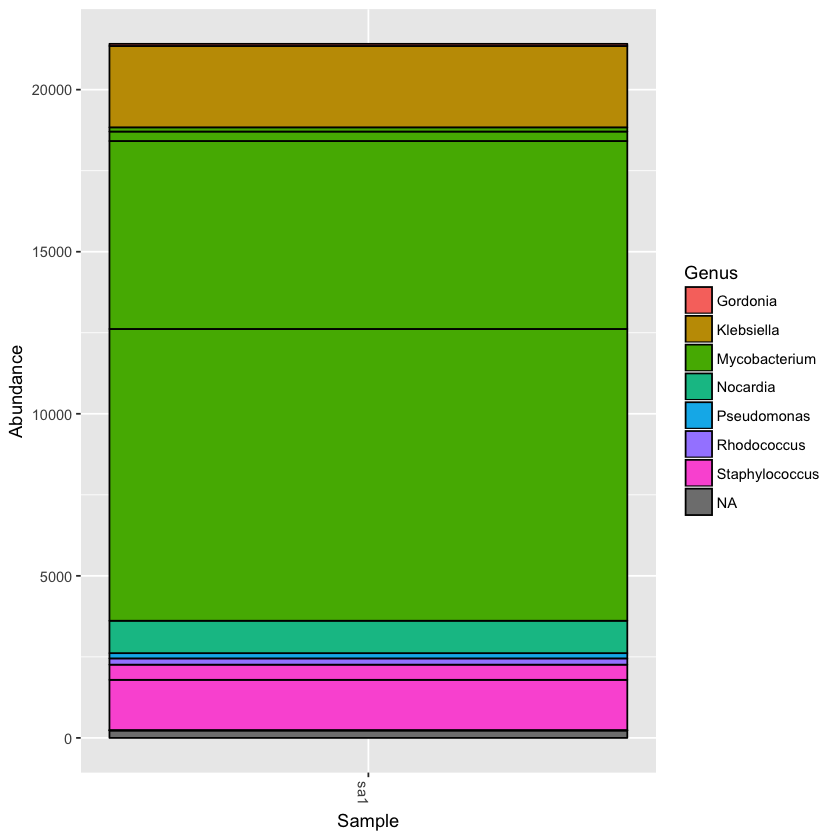

In [15]:
otu_glom<-tax_glom(ps, taxrank="Genus")

Percentage <- transform_sample_counts(ps, function(x) {(x/sum(x))})

percent = as.data.frame(t(Percentage@otu_table@.Data))
tax = as.data.frame(Percentage@tax_table)

percent$sa1 = percent$sa1*100
new_table = as.data.frame(tax$Genus)
new_table$percent = percent$sa1
colnames(new_table) = c("Genus", "Read Percentage")

plot_bar(ps, fill = "Genus")

In [16]:
new_table

Genus,Read Percentage
Mycobacterium,42.03791912
Mycobacterium,27.08041468
Klebsiella,11.72130382
Staphylococcus,7.23358550
Nocardia,4.66984216
Staphylococcus,2.18548613
Mycobacterium,1.36359391
NA,1.06472401
Rhodococcus,0.90127954
Pseudomonas,0.75651443


In [17]:
tab = as.data.frame(table(tax$Genus))
colnames(tab) = c("Genus", "Frequency")
tab

Genus,Frequency
Gordonia,1
Klebsiella,1
Mycobacterium,4
Nocardia,1
Pseudomonas,1
Rhodococcus,1
Staphylococcus,2


#### Merge Genus Level Counts

In [18]:
### Genus Level
b1 = tax_glom(ps, taxrank = "Genus")

tax_table = as.data.frame(ps@tax_table)
genus_set = as.character(unique(tax_table$Genus))
genus_set = genus_set[!is.na(genus_set)]


Genus = sort(taxa_sums(b1), TRUE)[1:7]
Genus = as.data.frame(Genus)

rownames(Genus) = genus_set
colnames(Genus) = c("Read Counts")
Genus

,Read Counts
Mycobacterium,15223
Klebsiella,2510
Staphylococcus,2017
Nocardia,1000
Rhodococcus,193
Pseudomonas,162
Gordonia,66
